In [1]:
from vis_eulag import *
SETTINGS = load_settings('settings_local_inGrav.txt')

import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate

import subroutines
plt.style.use('latex_default.mplstyle')

In [2]:
# fileLocations = ['/work/bd0620/b309199/translb3D_000_comp',]
# fileLocations = ['/scratch/b/b309199/inGrav3D_001', '/scratch/b/b309199/inGrav3D_002',
#                  '/scratch/b/b309199/inGrav3D_003', '/scratch/b/b309199/inGrav3D_004',
#                 '/scratch/b/b309199/inGrav3D_005', '/scratch/b/b309199/inGrav3D_006',
#                 '/scratch/b/b309199/inGrav3D_007', '/scratch/b/b309199/inGrav3D_008',
#                 '/scratch/b/b309199/inGrav3D_009', '/scratch/b/b309199/inGrav3D_008a',
#                 '/scratch/b/b309199/inGrav3D_008c']

fileLocations = ['/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_001a', '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_002a',
                 '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_003a', '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_004a',
                 '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_005a', '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_006a',
                 '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_007a', '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_008a',
                 '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_009a', '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_008b',
                 '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_008c']

# '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_009a'
# 9b and 9c show that reference state has no effect... and density scale height has minor effect... doesn'really change the picture
# 
# use 8b and 8c for comparison to higher horizontal and vertical resolution
# 

# fileLocations = ['/scratch/b/b309199/inGrav3D_005', '/scratch/b/b309199/inGrav3D_006',
#                  '/scratch/b/b309199/inGrav3D_007', '/scratch/b/b309199/inGrav3D_009']
# labels=['A', 'B']
    
ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime'] = ds['p'] # h12
    
    # ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

theoretical maximum: 0.785 (pi/4), actual max of curve: 0.770108753149593, a: 62999.99999999999


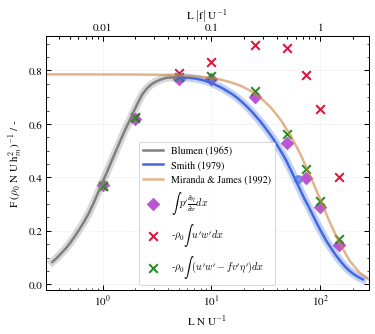

In [13]:
fig, ax0 = plt.subplots(1,1,figsize=(5.32,4.75))
lw_cross = 2
lwall = 2.5
c_smith = 'royalblue'
c_miranda = 'peru'
# - line representing linear theory - #
N=0.01
U=10
f=10**(-4)
linear_drag_array = np.loadtxt("drag_gill_page279.txt",usecols=(0, 1), skiprows=0)
nsplit = 28
# print(linear_drag_array[:,0])
# factor_corr = 1.05
factor_corr = 1.005
factor_corr_2 = 1.01
ax0.plot(linear_drag_array[:nsplit+1,0],linear_drag_array[:nsplit+1,1]*factor_corr, color='gray', lw=8, alpha=0.3)
ax0.plot(linear_drag_array[nsplit:,0],linear_drag_array[nsplit:,1]*factor_corr, color=c_smith, lw=8, alpha=0.3)
ax0.plot(linear_drag_array[:nsplit+1,0],linear_drag_array[:nsplit+1,1]*factor_corr, color='gray', lw=lwall, label='Blumen (1965)')
ax0.plot(linear_drag_array[nsplit:,0],linear_drag_array[nsplit:,1]*factor_corr, color=c_smith, lw=lwall, label='Smith (1979)')


a = 0.63*U/f
smith_x = a * N / U
smith = 0.5*np.pi/4 # drag dropped to half for af/U = 0.63 -> a = 63km
drag_max = np.max(linear_drag_array[:,1])
# smith = 0.5*drag_max # drag dropped to half for af/U = 0.63 -> a = 63km
print('theoretical maximum: 0.785 (pi/4), actual max of curve: {}, a: {}'.format(drag_max,a))
ax0.scatter(smith_x, smith, marker='o', s=50, color=c_smith, alpha=0.6, lw=lw_cross) # label='expl. specified (Smith 1979)'
# smith_x = 100000 * N / U
# smith = 0.28*np.pi/4 # af/U = 1 -> a = 100km
# ax0.scatter(smith_x, smith, marker='o', s=50, color='darkorchid', alpha=0.6, lw=lw_cross)
#
smith_x = 30000 * N / U
# smith = 0.8*np.pi/4 # af/U = 1 -> a = 100km
# ax0.scatter(smith_x, smith, marker='o', s=50, color='darkorchid', alpha=0.6, lw=lw_cross)

# ax0.annotate(tstr, (x_regime+, drag_angMom), color='y', transform=ax0.transAxes) # (Smith79)
        
# - Miranda and James - #
XML = np.logspace(1,10,100)
XVALUES = XML * N / U
mirandaJames = np.pi/4 * (1+2*f*XML/U)*np.exp(-2*f*XML/U)
ax0.plot(XVALUES,mirandaJames, color=c_miranda, alpha=0.6, lw=lwall, ls='-', label="Miranda & James (1992)")
# ax0.plot(XVALUES,mirandaJames*XML, color='darkgoldenrod', alpha=0.6, lw=2, ls='--', label=r"Miranda and James 1992")
D0 = ds['rh0'][0,0,0,0]*U*N*100**2
# print('D_0', D0)

i=0
z = 0
t=6
for ds in ds_list:
    if i==9 or i==10:
        continue
    # if i==7:
    #     i+=1
    #     continue
    # 8a with dz=50 and dx=2500 -> half
    # if i==5:
    #     t=5
    # else:
    #     t=6
    
    if ds.irelx:
        n_sponge=int(ds.dxabL/ds.dx00)
        # n_sponge=n_sponge+80
    else:
        n_sponge=0

    x_regime = ds.xml * ds.bv / ds['ue'][0,0,0,0]
    x_regime = x_regime.values
    
    y=int(ds.ny/2)
    
    # - Drag form pressure perturbation - #
    # drag = integrate.trapezoid(ds.pprime[t,z,y,:] * ds.dzdx_surf[y,:], 1000.*ds.xcr[y,:])
    drag = integrate.trapezoid(ds.pprime[t,z,y,n_sponge:ds.nx-n_sponge] * ds.dzdx_surf[y,n_sponge:ds.nx-n_sponge], 1000*ds.xcr[y,n_sponge:ds.nx-n_sponge]) # 0.3576
    # drag = integrate.trapezoid(ds.pprime[12,z,y,start:end] * ds.dzdx_surf[y,start:end], 1000*ds.xcr[y,start:end]) # 0.3576
    # drag = integrate.simps(ds.pprime[12,z,y,:] * ds.dzdx_surf[y,:], 1000*ds.xcr[y,:])

    # - Drag from vertical flux of angular momentum (vertical momentum flux + streamwise Coriolis force) - # 
    drag_vertMom = -ds['rh0'][0,z,0,0]*integrate.trapezoid((ds.u[t,z,y,n_sponge:ds.nx-n_sponge]-ds.ue[t,z,y,n_sponge:ds.nx-n_sponge])*ds.w[t,z,y,n_sponge:ds.nx-n_sponge], 1000.*ds.xcr[y,n_sponge:ds.nx-n_sponge])
    drag_vertMom_v = -ds['rh0'][0,z,0,0]*integrate.trapezoid((ds.v[t,z,y,n_sponge:ds.nx-n_sponge]-ds.ve[t,z,y,n_sponge:ds.nx-n_sponge])*ds.w[t,z,y,n_sponge:ds.nx-n_sponge], 1000.*ds.xcr[y,n_sponge:ds.nx-n_sponge])
    drag_f = ds.fcr0*np.sin(-ds.ang*np.pi/180) * ds['rh0'][0,z,0,0]*integrate.trapezoid((ds.v[t,z,y,n_sponge:ds.nx-n_sponge]-ds.ve[t,z,y,n_sponge:ds.nx-n_sponge])*1000.*ds.zcr[t,z,y,n_sponge:ds.nx-n_sponge], 1000.*ds.xcr[y,n_sponge:ds.nx-n_sponge])
    
    # ---- CALCULATE RHO' ---- #
    thloc = ds['the'][t,z,y,n_sponge:ds.nx-n_sponge] + ds['th'][t,z,y,n_sponge:ds.nx-n_sponge] # Theta
    tloc = thloc*(ds['pr0'][t,z,y,n_sponge:ds.nx-n_sponge]/ds['pref00'])**ds.cap # T
    # tte = ds['the'][t,z,:,:]*(ds['pr0'][t,z,:,:]/ds['pref00'])**ds.cap # T_env
    ploc = ds['pprime'][t,z,y,n_sponge:ds.nx-n_sponge]+ds['pr0'][t,z,y,n_sponge:ds.nx-n_sponge]
    rholoc = ploc/(ds.rg*tloc)
    rhoprime = rholoc-ds['rhe'][t,z,y,n_sponge:ds.nx-n_sponge]
    drag_compressible = ds.fcr0*np.sin(-ds.ang*np.pi/180) * integrate.trapezoid(rhoprime * (ds.v[t,z,y,n_sponge:ds.nx-n_sponge]-ds.ve[t,z,y,n_sponge:ds.nx-n_sponge]) * 1000.*ds.zcr[t,z,y,n_sponge:ds.nx-n_sponge], 1000.*ds.xcr[y,n_sponge:ds.nx-n_sponge])

    # print('f: ', str(ds.fcr0*np.sin(-ds.ang*np.pi/180)))
    # f=1.031

    # - Normalized drag - #
    # normalized_drag = drag / (0.25*np.pi*ds['rh0'][0,0,0,0] * ds.bv * ds['ue'][0,0,0,0] * ds.amp**2)
    drag = drag / (ds['rh0'][0,0,0,0] * ds.bv * ds['ue'][0,0,0,0] * ds.amp**2)
    drag_vertMom = drag_vertMom / (ds['rh0'][0,0,0,0] * ds.bv * ds['ue'][0,0,0,0] * ds.amp**2)
    drag_vertMom_v = drag_vertMom_v / (ds['rh0'][0,0,0,0] * ds.bv * ds['ue'][0,0,0,0] * ds.amp**2)
    drag_f = drag_f / (ds['rh0'][0,0,0,0] * ds.bv * ds['ue'][0,0,0,0] * ds.amp**2)
    drag_compressible = drag_compressible / (ds['rh0'][0,0,0,0] * ds.bv * ds['ue'][0,0,0,0] * ds.amp**2)
    drag_angMom = drag_vertMom + drag_f
    drag_angMom_compressible = drag_vertMom + drag_f + drag_compressible # + drag_vertMom_v
    ## drag_angMom = - drag_angMom
    
    if (i==9 or i==10 or i==11): # 9 and 10 are dx/2 and dz/2, 11 optional
        c1 = 'steelblue'
        c2 = 'steelblue'
        a1 = 1
        mark1 = '+'
        mark2 = '+'
        ss = 150
    else:
        c1 = 'forestgreen'
        c2 = 'mediumorchid'
        c3 = 'crimson'
        a1 = 1
        mark1 = 'D'
        mark2 = 'x'
        mark3 = '.'
        ss = 75
        
    if i==0:  
        ax0.scatter(x_regime, drag, marker=mark1, s=ss, color=c2, alpha=a1, label=r"$\int$ $p' \frac{\partial \eta}{\partial x} dx$")
        ax0.scatter(x_regime, drag_vertMom, marker=mark2, s=ss, color=c3, alpha=a1, lw=lw_cross, label=r"-$\rho_0 \int$ $u'w' dx$")
        ax0.scatter(x_regime, drag_angMom, marker=mark2, s=ss, color=c1, alpha=a1, lw=lw_cross, label=r"-$\rho_0 \int$ $(u'w' - fv' \eta')dx$")
        # ax0.annotate(tstr, (x_regime+seperation, drag), color=c1,transform=ax0.transAxes)
    elif i==9:  
        ax0.scatter(x_regime, drag, marker=mark1, s=ss, color=c2, alpha=a1, lw=lw_cross, label=r"$\frac{\Delta x}{2}$ & $\frac{\Delta z}{2}$")
        ax0.scatter(x_regime, drag_angMom, marker=mark2, s=ss, color=c1, alpha=a1, lw=lw_cross)
        # ax0.annotate(tstr, (x_regime+seperation, drag), color=c1,transform=ax0.transAxes)
        
    else:
        ax0.scatter(x_regime, drag, marker=mark1, s=ss, color=c2,alpha=a1)
        if i!=10:
            ax0.scatter(x_regime, drag_vertMom, marker=mark2, s=ss, color=c3, alpha=a1, lw=lw_cross)
        ax0.scatter(x_regime, drag_angMom, marker=mark2, s=ss, color=c1, alpha=a1, lw=lw_cross)
        # ax0.scatter(x_regime, drag_angMom_compressible, marker=mark3, s=ss, color=c1, alpha=a1, lw=lw_cross)
        
        # ax0.annotate(tstr, (x_regime+seperation, drag), color=c1, alpha=a1, transform=ax0.transAxes)
    
    # - Smith (1979)
    # if ds.xml == 100000:
    #     smith = 0.28*0.78
    #     ax0.scatter(x_regime, smith, marker='o', s=50, color='darkorchid', alpha=0.6, lw=lw_cross, label='Smith (1979)')

    i+=1
    
# - Formatting and saving - #
xtick_labels_top = ['xx','xx','0.01','0.1','1']

ax0.set_ylim([-0.02,0.93])
ax0.set_xlim([3*10**(-1),2.8*10**(2)])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.set_xscale('log')
# ax0.legend(loc='upper left')
ax0.legend(loc='lower center')
# ax0.set_ylabel(r'F ($\rho_0$ N U h$_m^2$)$^{-1}$ / -')
ax0.set_ylabel(r'F ($\rho_0$ N U h$_m^2$)$^{-1}$ / -')
ax0.set_xlabel(r'L N U$^{-1}$')
# ax0.tick_params(labeltop=True)
ax0.grid()

ax_t = ax0.secondary_xaxis('top')
ax_t.set_xticklabels(xtick_labels_top)
ax_t.set_xlabel(r"L $|$f$|$ U$^{-1}$")


# ax0.xaxis.set_minor_locator(AutoMinorLocator())
# ax0.tick_params(which='minor', top=True)
# ax_t.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig_title = 'GWD-linearTheory-Q3D' + '.png'
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
"""
# fileLocations = ['/work/bd0620/b309199/translb3D_000_comp',]
fileLocations = ['/scratch/b/b309199/inGrav3D_000', '/scratch/b/b309199/inGrav3D_002']
labels=['A', 'B']
    
ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap

    ds.attrs['cp'] = np.round(ds.attrs['cp'],3) # .round(3)
    ds.attrs['cap'] = np.round(ds.attrs['cap'])
    ds.attrs['capp'] = np.round(ds.attrs['capp'])
    ds.attrs['compri'] = np.round(ds.attrs['compri'])
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime'] = ds['p'] # h12
    
    # ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)
"""